## Setup

In [1]:
from torch import nn
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os
sns.set()
palette = sns.color_palette()
os.chdir("/Users/mingyu/Desktop/ICA") 

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## 1. Metrics: Procrustes vs. CCA

In [3]:
from sklearn.cross_decomposition import CCA
from scipy.spatial import procrustes
import scipy.stats
exp_path = "/Volumes/Sumsung_1T/ICA/vae_exp/trial_0"

In [4]:
activation = nn.LeakyReLU()
m, n = 2, 7

In [5]:
# load x and mean
activation_name = ''.join([_ for _ in re.sub("[\(\[].*?[\)\]]", "", str(activation)) if _.isalpha()])
model_path = os.path.join(exp_path, f"m{m}_n{n}_{activation_name}")
simu_df = pd.read_csv(os.path.join(model_path, "simu_df.csv"))
recon_df = pd.read_csv(os.path.join(model_path, "recon_df.csv"))
x = simu_df.loc[:, [_ for _ in simu_df.columns if "x" in _]]
mean = recon_df.loc[:, [_ for _ in recon_df.columns if "mean" in _]]

In [6]:
# find disp & CCA
disp = procrustes(x, mean)[2]
cca = CCA(n_components=1)
x_c, mean_c = cca.fit_transform(x, mean)
corr, _ = scipy.stats.pearsonr(x_c.reshape(-1), mean_c.reshape(-1))
print(f"Working on m={m}, n={n} -- disp = {round(disp, 3)} and corr = {round(corr, 3)}")

Working on m=2, n=7 -- disp = 0.363 and corr = 0.975


### 1.1 Typical Rates

On the metrics for comparing the original data and the reconstructed data:

- `Procrustes analysis` — given two identically sized matrices, Procrustes analysis standardizes both such that i) `tr(AA^T)=1` and ii) both sets of points are centered around the origin. Procrustes then applies the optimal transform to the second matrix (scaling, rotations, and reflections) to minimize the sum of the squares of the point-wise differences between the two input datasets. The advantage is that matrices with different dimensions & different scales are normalized such that they can be compared under this construct. Additionally, the method does not introduce any spurious correlation arising from a pattern similar to “selective inference” that occurs for `CCA` when comparing matrices with different dimensions.

- `CCA` — CCA repeatedly finds pairs of canonical variables for which the canonical correlation is maximized (with conditions on the correlation between the current canonical variables and previous ones). It is helpful when comparing matrices with the same dimension but is less useful for comparing matrices across different dimensions — some variables can be correlated by random chance. As dimension increases, the best pair of vectors (with `n_components=1`) for aligning the canonical variables tends to pick up these spurious correlations, making the correlation larger than lower-dimensional matrices. To make this metric useful, we need to look beyond the first canonical correlation.

In [7]:
import numpy as np
import scipy.spatial 
from sklearn.cross_decomposition import CCA
n_samples = 5000
num_lin, n_min, n_max = 15, 2, 500
n_li = list(np.round(np.exp(np.linspace(np.log(n_min), np.log(n_max), num_lin))).astype(int))

for n in n_li:
    mtx_a = np.random.randn(n_samples, n)
    mtx_b = np.random.randn(n_samples, n)
    
    disp = procrustes(mtx_a, mtx_b)[2]
    cca = CCA(n_components=1)
    mtx_ac, mtx_bc = cca.fit_transform(mtx_a, mtx_b)
    corr, _ = scipy.stats.pearsonr(mtx_ac.reshape(-1), mtx_bc.reshape(-1))
    
    print(f"Working on n_samples={n_samples}, n={n} -- disp = {round(disp, 3)} and corr = {round(corr, 3)}")

Working on n_samples=5000, n=2 -- disp = 1.0 and corr = 0.02
Working on n_samples=5000, n=3 -- disp = 1.0 and corr = 0.035
Working on n_samples=5000, n=4 -- disp = 1.0 and corr = 0.033
Working on n_samples=5000, n=7 -- disp = 0.999 and corr = 0.059
Working on n_samples=5000, n=10 -- disp = 0.999 and corr = 0.082
Working on n_samples=5000, n=14 -- disp = 0.998 and corr = 0.099
Working on n_samples=5000, n=21 -- disp = 0.997 and corr = 0.11
Working on n_samples=5000, n=32 -- disp = 0.996 and corr = 0.156
Working on n_samples=5000, n=47 -- disp = 0.994 and corr = 0.179
Working on n_samples=5000, n=70 -- disp = 0.99 and corr = 0.222
Working on n_samples=5000, n=103 -- disp = 0.985 and corr = 0.281
Working on n_samples=5000, n=153 -- disp = 0.978 and corr = 0.336
Working on n_samples=5000, n=227 -- disp = 0.968 and corr = 0.411
Working on n_samples=5000, n=337 -- disp = 0.952 and corr = 0.498
Working on n_samples=5000, n=500 -- disp = 0.929 and corr = 0.595


### 1.2 VAE Scaling

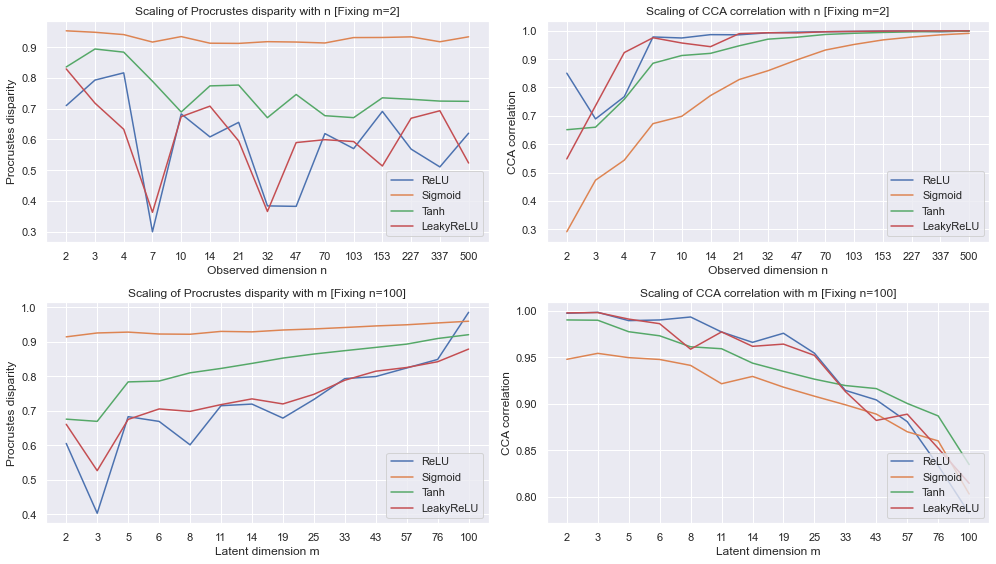

In [8]:
from visualization.scaling import plot_scaling
fig = plot_scaling("/Volumes/Sumsung_1T/ICA/vae_exp/trial_0")

### 1.3 MLE Scaling

In [9]:
# from visualization.scaling import plot_scaling
# fig = plot_scaling("/Volumes/Sumsung_1T/MLE/vae_exp/trial_0")

## 2. Models: VAE vs. MLE

### 2.1 VAE
- **Pros:** Good computational scaling and efficiency (although training can be unstable for large m and n, heavily relying on initialization) 
- **Cons:** ELBO — the quality of reconstruction is the best for variational distribution (rather than prior)
- **Notes:** Computational scaling can be instable (e.g. the optimizer produces invalid values for `m=100, n=100`)

In [10]:
def plot_recon_2d(m, n, exp_path, column):
    """ Spinet from visualization.recon.plot_recon_2d """
    
    assert column in ["x_recon", "mean"]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # load simu_df and recon_df and perform PCA
    activation_name = ''.join([_ for _ in re.sub("[\(\[].*?[\)\]]", "", str(activation)) if _.isalpha()])
    simu_pca, recon_pac = PCA(n_components=2), PCA(n_components=2)
    model_path = os.path.join(exp_path, f"m{m}_n{n}_{activation_name}")
    simu_df = pd.read_csv(os.path.join(model_path, "simu_df.csv"), index_col=0)
    recon_df = pd.read_csv(os.path.join(model_path, "recon_df.csv"), index_col=0)
    simu_2d = simu_pca.fit_transform(simu_df.loc[:, [_ for _ in simu_df.columns if "x" in _]])
    recon_2d = recon_pac.fit_transform(recon_df.loc[:, [_ for _ in recon_df.columns if column in _]])
    simu_2d_df = pd.DataFrame(simu_2d, columns=["pc0", "pc1"])
    recon_2d_df = pd.DataFrame(recon_2d, columns=["pc0", "pc1"])

    # tiny perturbation to avoid exactly same values
    recon_2d_df["pc0"] = recon_2d_df["pc0"] + np.random.normal(loc=0.0, scale=1e-6, size=recon_2d_df.shape[0])
    recon_2d_df["pc1"] = recon_2d_df["pc1"] + np.random.normal(loc=0.0, scale=1e-6, size=recon_2d_df.shape[0])

    # visualization of the 2d PCA distribution
    sns.kdeplot(data=simu_2d_df, x="pc0", y="pc1", fill=True, alpha=1., ax=ax)
    sns.kdeplot(data=recon_2d_df, x="pc0", y="pc1", fill=True, alpha=.7, ax=ax)
    s2 = np.round(np.mean(np.exp(recon_df["logs2"])), 3)
    ax_legend_true = mpatches.Patch(color=palette[0], label="Observed $p(x|z)$", alpha=0.8)
    ax_legend_recon = mpatches.Patch(color=palette[1], label="Recon $\widehat{p}(x|z)$", alpha=0.8)
    ax_legend_s2 = mpatches.Patch(color=palette[7], label="$\widehat{\sigma}^2$" + f"={s2}", alpha=0.8)
    handles = [ax_legend_true, ax_legend_recon, ax_legend_s2]
    ax.legend(handles=handles, loc="upper right", handlelength=0.2, handletextpad=0.5)
    ax.set_title(f"Reconstruction of {activation_name}")
    ax.set_xlabel("PC0")
    ax.set_ylabel("PC1")

In [11]:
activation = nn.LeakyReLU()
m, n = 2, 7

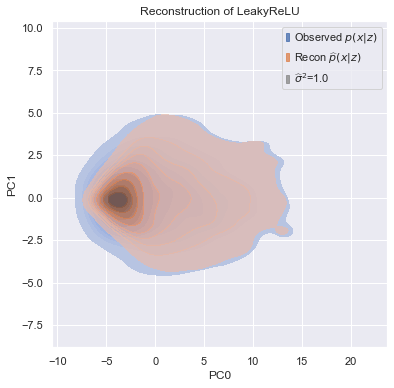

In [12]:
exp_path = "/Volumes/Sumsung_1T/ICA/vae_exp/trial_0"
plot_recon_2d(m, n, exp_path, column="x_recon")

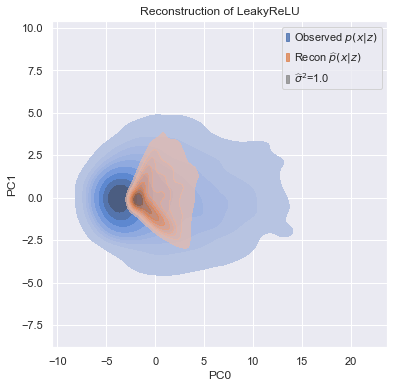

In [13]:
exp_path = "/Volumes/Sumsung_1T/ICA/vae_exp/trial_0"
plot_recon_2d(m, n, exp_path, column="mean")

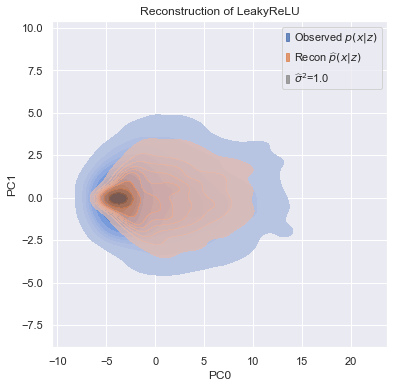

In [14]:
exp_path = "/Volumes/Sumsung_1T/ICA/mleauto_exp/trial_0"
plot_recon_2d(m, n, exp_path, column="mean")

### 2.2 MLE
- **Pros:** The quality of reconstruction is better when MLE succeeds (need to verify more carefully with outputs from Procrustes analysis)
- **Cons:** The need for numerical integration — computationally inefficient
- **Cons:** The need for likelihood — bad computational scaling (e.g. cannot easily scale to `m=2, n=15`)

## Appendix: Notes
- Make the experiments scalable to multiple trials
- Remove repeated `get_llh_mc` in `mlesgd` to reduce computational cost
- Built `get_llh_null` for `vae` to reduce computational cost in large experiments
- Reduce `epochs` the computational burden for MLE
- Support for both `mean` and `x_recon` in VAE output
- Support for both `Procrustes` and `CCA`
- Disabled `shuffle` in data loader 
- Enabled `seed` in dpg to generate different inputs
- Plotted typical rate with Gaussian noise matrices
- Support multiprocessing across the four activation functions
- Add function for plotting scaling